In [9]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def createDataFrame(stock, start, end):
    df = stock.history(start=start, end=end)

    df["Change"] = df["Close"].pct_change() # 전날 대비 변화율
    # df.index = pd.to_datetime(df.index).strftime("%Y-%m-%d") # 날짜 형식 간단하게 만들기
	
    # 지표 데이터
    # df2 = pd.read_csv("/Users/ryujonghyeok/Jonghyeok/Sejong/SAI/자료모음집.csv") 
    # df = pd.merge(df, df2, on="Date") """

    # df.set_index("Date", inplace=True)

    return df

In [19]:
def buy(현금보유량, 주식보유량, 현재주가):
    if 주식보유량 == 0:
        주식보유량 = 현금보유량 // 현재주가
        현금보유량 -= 주식보유량 * 현재주가
        # print(f"Bought at {현재주가} with {주식보유량} stocks")
    return 현금보유량, 주식보유량


def sell(현금보유량, 주식보유량, 현재주가):
    if 주식보유량 > 0:
        현금보유량 += 주식보유량 * 현재주가
        주식보유량 = 0
        # print(f"Sold at {현재주가} with {주식보유량} stocks")
    return 현금보유량, 주식보유량

def total_asset(현금보유량, 주식보유량, 현재주가):
    return 현금보유량 + 주식보유량 * 현재주가

In [20]:
""" def score_calculate(i):
    bullishWords = {'rally': 0.2074, 'rise': 0.1983, 'high': 0.1416, 'gain': 0.0460, 'up': 0.0678, 'recovery': 0.0278, 'soar': 0.0056, 'bull': 0.0010, 'boom': 0.0010} # 상승 🤑
    bearishWords = {'fall': 0.1103, 'low': 0.0597, 'drop': 0.0465, 'down': 0.0288, 'decline': 0.0243, 'sink': 0.0137, 'recession': 0.0101, 'loss': 0.0061, 'bear': 0.0040} # 하락 🤑

    물가지수 = df.iloc[i]["물가지수"]
    콜금리 = df.iloc[i]["콜금리"]
    회사채금리 = df.iloc[i]["회사채"]
    주택매매지수 = df.iloc[i]["주택지수"]
    국민총소득 = df.iloc[i]["GNI"]

    뉴스 = df.iloc[i]["Title"]

    score = (-51.2)*물가지수 + (-306.67)*콜금리 + (40.01)*회사채금리 + 26.84*주택매매지수 + 4.35*국민총소득 # 🤑

    for word in 뉴스.split():
        if word in bullishWords:
            score += bullishWords[word] * 500 # 🤑
        elif word in bearishWords:
            score -= bearishWords[word] * 500 # 🤑

    return score """

""" score_plt = []
# 복합적인 요소를 분석하여 일정 조건에 따라 매수 및 매도 반복
def strategy_score(df):
    global score_plt

    현금보유량 = 1000000
    주식보유량 = 0

    현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, df.iloc[0].Close)
    for i in range(len(df)):
        
        # 점수 계산하기
        score = score_calculate(i)

        현재주가 = df.iloc[i].Close

        # 점수가 일정 기준보다 클 때 매수하기
        if score > 50: # 🤑
            현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, 현재주가)

        # 점수가 일정 기준보다 작을 때 매도하기
        elif score < -900: # 🤑
            현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, 현재주가)

        score_plt.append(total_asset(현금보유량, 주식보유량, 현재주가))

    현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, df.iloc[-1].Close)


    print(f"가중치 계산 - 현금보유량: {현금보유량:.2f} profit: {(현금보유량-1000000)/1000000*100:.2f}%")
 """

' score_plt = []\n# 복합적인 요소를 분석하여 일정 조건에 따라 매수 및 매도 반복\ndef strategy_score(df):\n    global score_plt\n\n    현금보유량 = 1000000\n    주식보유량 = 0\n\n    현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, df.iloc[0].Close)\n    for i in range(len(df)):\n        \n        # 점수 계산하기\n        score = score_calculate(i)\n\n        현재주가 = df.iloc[i].Close\n\n        # 점수가 일정 기준보다 클 때 매수하기\n        if score > 50: # 🤑\n            현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, 현재주가)\n\n        # 점수가 일정 기준보다 작을 때 매도하기\n        elif score < -900: # 🤑\n            현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, 현재주가)\n\n        score_plt.append(total_asset(현금보유량, 주식보유량, 현재주가))\n\n    현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, df.iloc[-1].Close)\n\n\n    print(f"가중치 계산 - 현금보유량: {현금보유량:.2f} profit: {(현금보유량-1000000)/1000000*100:.2f}%")\n '

In [21]:
buyAndHold_plt = []
# 시작시점에 매수 후 종료시점에 매도
def strategy_buyAndHold(df):
    global buyAndHold_plt

    현금보유량 = 1000000
    주식보유량 = 0

    현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, df.iloc[0].Close)
    
    buyAndHold_plt = []
    for i in range(1, len(df)-1):
        buyAndHold_plt.append(total_asset(현금보유량, 주식보유량, df.iloc[i].Close))
    
    현금보유량 += 주식보유량 * df.iloc[-1].Close

    print(f"그냥 가만히 - 현금보유량: {현금보유량:.2f}, profit: {(현금보유량-1000000)/1000000*100:.2f}%")


In [22]:
difference_plt = []
# 최고점 대비 일정 비율 하락하면 매도, 최저점 대비 일정 비율 상승하면 매수
def strategy_difference(df):
    global difference_plt
    현금보유량 = 1000000
    주식보유량 = 0
    dif1 = 0.36 # 일정 비율 하락하는 정도 🤑
    dif2 = 0.02 # 일정 비율 상승하는 정도 🤑

    minimum = float('inf')
    maximum = float('-inf')

    for i in range(2, len(df)):
        price = df.iloc[i].Close
        if price > maximum:
            maximum = price
        elif price < minimum:
            minimum = price
        if 주식보유량 > 0 and price < maximum * (1-dif1):
        #print(f"Sold at {price(hist, i)}")
            현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, price)
            maximum = float('-inf')
        elif 주식보유량 == 0 and price > minimum * (1+dif2):
            #print(f"Bought at {price(hist, i)}")
            현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, price)
            minimum = float('inf')

        difference_plt.append(total_asset(현금보유량, 주식보유량, price))

    현금보유량 += 주식보유량 * df.iloc[-1].Close
    주식보유량 = 0

    print(f"변화율 비교 - 현금보유량: {현금보유량:.2f}, profit: {(현금보유량-1000000)/1000000*100:.2f}%")

Note: you may need to restart the kernel to use updated packages.


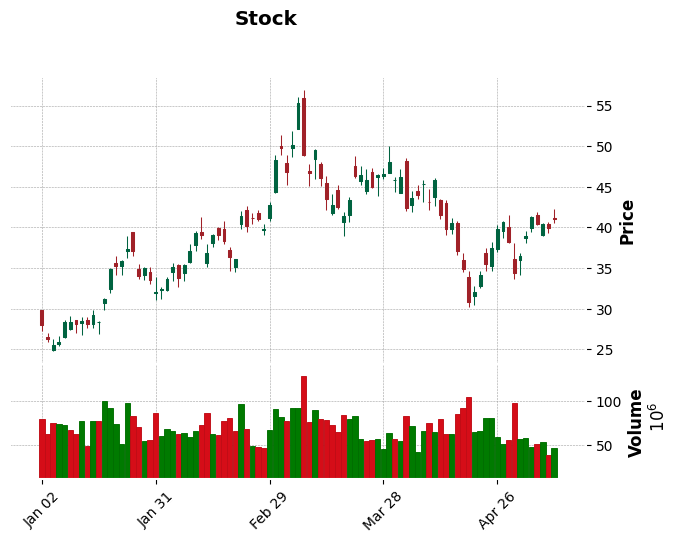

In [23]:
%pip install mplfinance
import mplfinance as mpf

def plot(df):
    mpf.plot(df, type='candle', volume=True, style='charles', title='Stock', ylabel='Price', ylabel_lower='Volume')

    plt.plot(buyAndHold_plt, label="Buy and Hold")
    plt.plot(difference_plt, label="Difference")
    # plt.plot(score_plt, label="Score")
    plt.legend()
    plt.show()

# Stock 정의하기
stock = yf.Ticker("SOXL")

# 데이터프레임 만들기
start="2024-01-01"
end="2024-12-31"

df = createDataFrame(stock, start, end)

mpf.plot(df, type='candle', volume=True, style='charles', title='Stock', ylabel='Price', ylabel_lower='Volume')



In [24]:
def score_calculate(i):
    # https://www.investrade.com/market-review-may-10-2024/
    pass

# plt: for the purporse of plotting
score_plt = []
def strategy_score(df):
    global score_plt

    현금보유량 = 1000000
    주식보유량 = 0

    현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, df.iloc[0].Close)
    for i in range(len(df)):
        
        # 점수 계산하기
        score = score_calculate(i)

        현재주가 = df.iloc[i].Close

        # 점수가 일정 기준보다 클 때 매수하기
        if score > 50: # 🤑
            현금보유량, 주식보유량 = buy(현금보유량, 주식보유량, 현재주가)

        # 점수가 일정 기준보다 작을 때 매도하기
        elif score < -900: # 🤑
            현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, 현재주가)

        score_plt.append(total_asset(현금보유량, 주식보유량, 현재주가))

    현금보유량, 주식보유량 = sell(현금보유량, 주식보유량, df.iloc[-1].Close)


    print(f"가중치 계산 - 현금보유량: {현금보유량:.2f} profit: {(현금보유량-1000000)/1000000*100:.2f}%")

DatetimeIndex(['2024-01-02 00:00:00-05:00', '2024-01-03 00:00:00-05:00',
               '2024-01-04 00:00:00-05:00', '2024-01-05 00:00:00-05:00',
               '2024-01-08 00:00:00-05:00', '2024-01-09 00:00:00-05:00',
               '2024-01-10 00:00:00-05:00', '2024-01-11 00:00:00-05:00',
               '2024-01-12 00:00:00-05:00', '2024-01-16 00:00:00-05:00',
               '2024-01-17 00:00:00-05:00', '2024-01-18 00:00:00-05:00',
               '2024-01-19 00:00:00-05:00', '2024-01-22 00:00:00-05:00',
               '2024-01-23 00:00:00-05:00', '2024-01-24 00:00:00-05:00',
               '2024-01-25 00:00:00-05:00', '2024-01-26 00:00:00-05:00',
               '2024-01-29 00:00:00-05:00', '2024-01-30 00:00:00-05:00',
               '2024-01-31 00:00:00-05:00', '2024-02-01 00:00:00-05:00',
               '2024-02-02 00:00:00-05:00', '2024-02-05 00:00:00-05:00',
               '2024-02-06 00:00:00-05:00', '2024-02-07 00:00:00-05:00',
               '2024-02-08 00:00:00-05:00', '2024-0

ValueError: x and y must have same first dimension, but have shapes (91,) and (445,)

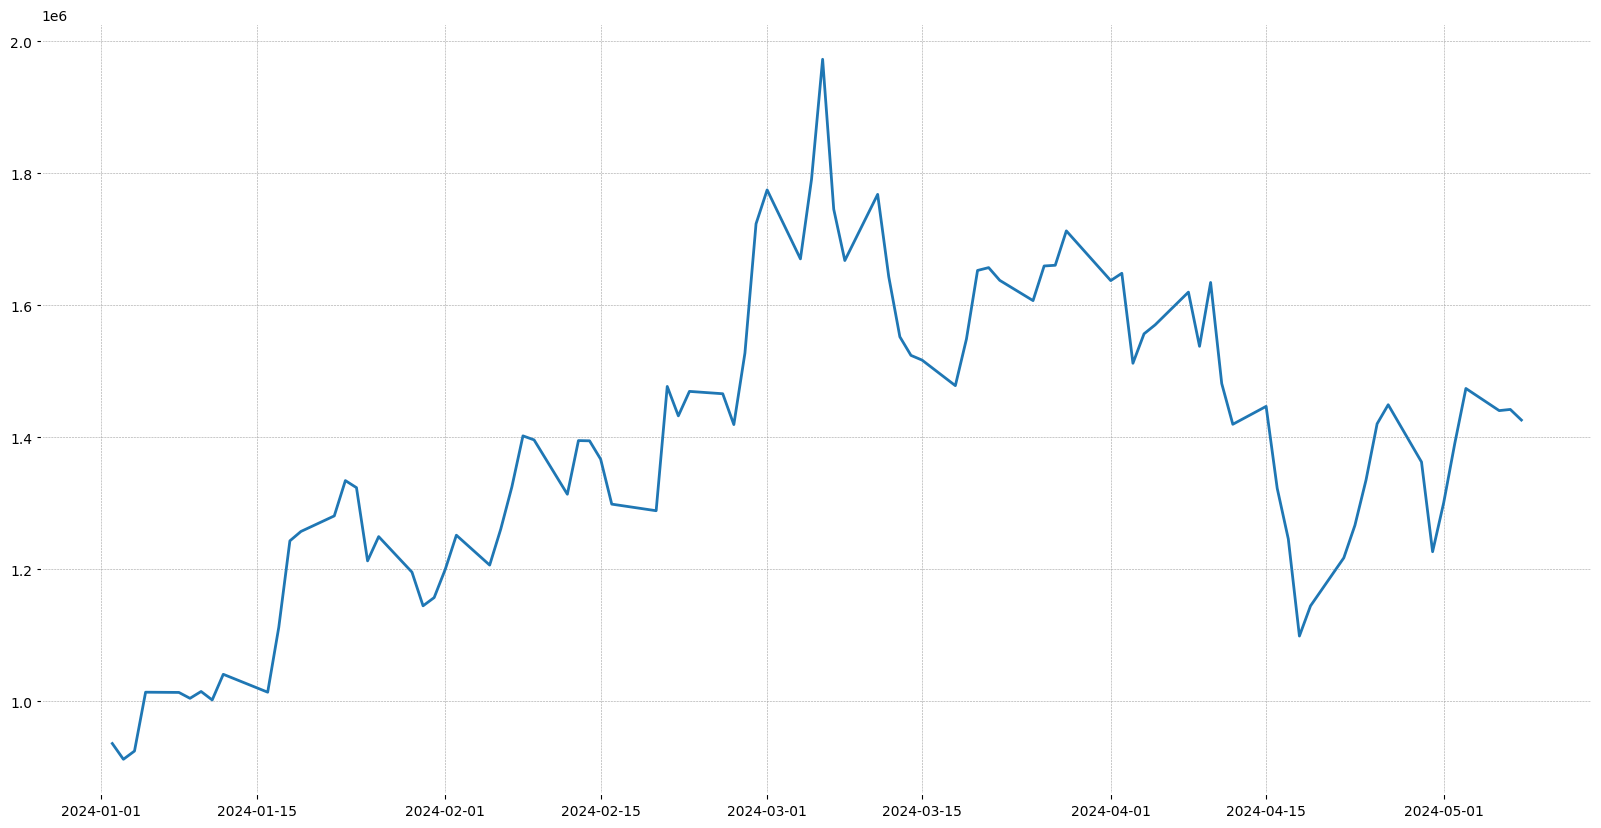

In [29]:
# Stock 정의하기
stock = yf.Ticker("SOXL")

# 데이터프레임 만들기
start="2024-01-01"
end="2024-12-31"

df = createDataFrame(stock, start, end)

strategy_buyAndHold(df)
strategy_difference(df)
#strategy_score(df)

# 그래프 그리기
plt.figure(figsize=(20, 10))
plt.plot(df.index[:-2], buyAndHold_plt, label="buyAndHold")
plt.plot(df.index[:-2], difference_plt, label="difference")
# plt.plot(df.index, score_plt, label="score")
plt.legend()
plt.show()